In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
import xgboost as xgb
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
#train.csv为有label的数据
#test.csv为无label的数据

df_train = pd.read_csv('/home/liyin_work/机器学习/房屋租金价格预测/data/train.csv')
df_test = pd.read_csv('/home/liyin_work/机器学习/房屋租金价格预测/data/test.csv')

In [3]:
df_train.describe()

,ID,区域1,区域2,区域3,街道,房屋租金,服务费,供暖费用,电力基础价格,没有停车位,...,加热类型,房屋类型,邮政编码,房间数量,所处楼层,建筑楼层,最后翻新年份,建成年份,价格趋势,上传图片数
count,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,2.000000e+05,194878.000000,63507.000000,34806.000000,69183.000000,...,199881.000000,195799.000000,200000.000000,200000.000000,161736.000000,127329.000000,60166.000000,157522.000000,198679.00000,200000.000000
mean,99999.500000,5.11352,112.193435,1452.648445,8684.393950,7.050609e+02,150.694673,77.473713,89.115567,1.337482,...,2.383513,1.779018,1466.059120,2.638721,2.122106,3.573703,2013.928747,1966.374310,3.38789,9.789215
std,57735.171256,4.38307,102.461610,1570.143349,11463.243457,2.253782e+04,125.662569,161.982694,5.392918,9.362136,...,2.354078,2.481294,1383.885453,1.977911,3.731785,6.622676,10.551631,46.906557,1.96158,6.399923
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,71.430000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,1867.000000,1007.000000,-9.17000,0.000000
25%,49999.750000,1.00000,32.000000,307.000000,1.000000,3.381000e+02,95.000000,54.000000,90.760000,1.000000,...,1.000000,0.000000,365.000000,2.000000,1.000000,2.000000,2012.000000,1950.000000,2.00000,6.000000
50%,99999.500000,5.00000,74.000000,879.000000,3136.000000,4.900000e+02,135.000000,70.000000,90.760000,1.000000,...,1.000000,1.000000,1034.000000,3.000000,2.000000,3.000000,2017.000000,1973.000000,3.39000,9.000000
75%,149999.250000,8.00000,176.000000,2064.000000,13570.250000,7.990000e+02,190.000000,90.000000,90.760000,1.000000,...,3.000000,2.000000,2169.000000,3.000000,3.000000,4.000000,2019.000000,1996.000000,4.57000,13.000000
max,199999.000000,15.00000,418.000000,8225.000000,44189.000000,9.999999e+06,25000.000000,12613.000000,90.760000,2241.000000,...,12.000000,9.000000,7218.000000,560.000000,999.000000,999.000000,2919.000000,2090.000000,12.87000,121.000000


## 上传日期

In [4]:
df_train['上传日期'].unique()

array(['Oct19', 'Feb20', 'May19', 'Sep18'], dtype=object)

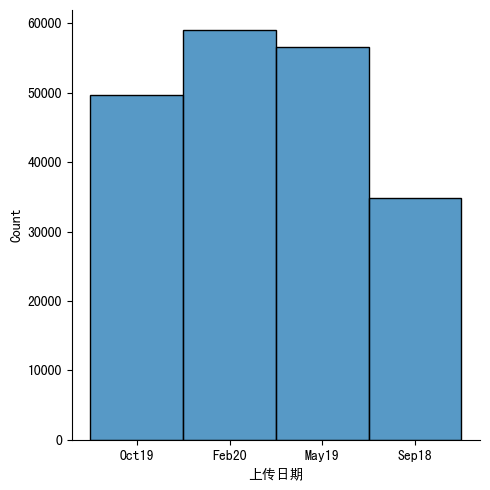

In [5]:
sns.displot(df_train['上传日期'])

In [6]:
#将上传日期分割成day和month两个特征
df_train['上传日期_day'] = df_train['上传日期'].apply(lambda x: int(x[-2:]))
df_test['上传日期_day'] = df_test['上传日期'].apply(lambda x: int(x[-2:]))

In [7]:
df_train['上传日期_month'] = df_train['上传日期'].apply(lambda x: x[:3])
df_test['上传日期_month'] = df_test['上传日期'].apply(lambda x: x[:3])

In [8]:
df_train['上传日期_month'] = df_train['上传日期_month'].apply(lambda x: ['Feb','May','Sep','Oct'].index(x))
df_test['上传日期_month'] = df_test['上传日期_month'].apply(lambda x: ['Feb','May','Sep','Oct'].index(x))

In [9]:
#将上传日期这列删除
df_train.drop(['上传日期'], axis=1, inplace=True)
df_test.drop(['上传日期'], axis=1, inplace=True)

## 可带宠物

In [10]:
df_train['可带宠物'].unique()

array(['negotiable', 'no', nan, 'yes'], dtype=object)

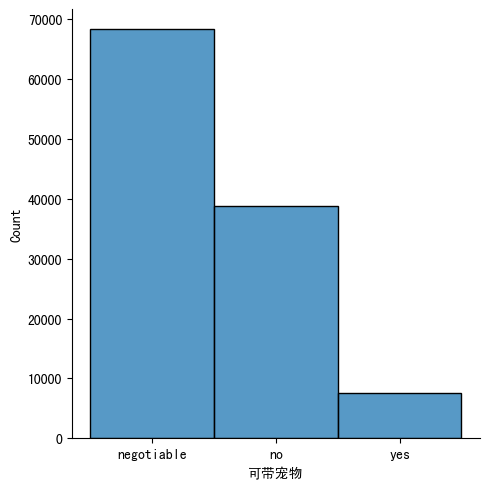

In [11]:
sns.displot(df_train['可带宠物'])

In [12]:
df_train['可带宠物'] = df_train['可带宠物'].map({'negotiable':0.5,'no':0,'yes':1})
df_test['可带宠物'] = df_test['可带宠物'].map({'negotiable':0.5,'no':0,'yes':1})

## bool类型的特征

In [13]:
for col in df_train.select_dtypes(bool).columns:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

## 房屋租金

In [14]:
# 查看有无零租金
index_zero = df_train.loc[df_train['房屋租金'] == 0].index
print('房屋租金价格为0的数量有{}'.format(len(index_zero)))

房屋租金价格为0的数量有68


In [15]:
#剔除房屋租金为0的异常值
df_train.drop(index=index_zero, inplace=True)
df_train = df_train.reset_index(drop=True)

## 居住面积

In [18]:
#查看有无居住面积为0的
index_zero_sq = df_train.loc[df_train['居住面积'] == 0].index
print('居住面积为0的数量有{}'.format(len(index_zero_sq)))

居住面积为0的数量有52


In [19]:
#剔除居住面积0的异常值
df_train.drop(index=index_zero_sq,inplace=True)
df_train = df_train.reset_index(drop=True)

## 将房屋租金和居住面积和其他特征组合进行特征衍生

In [20]:
#可得每平米价格
df_train['每平米价格'] = df_train['房屋租金'] / df_train['居住面积']

<AxesSubplot:xlabel='房屋租金', ylabel='Density'>

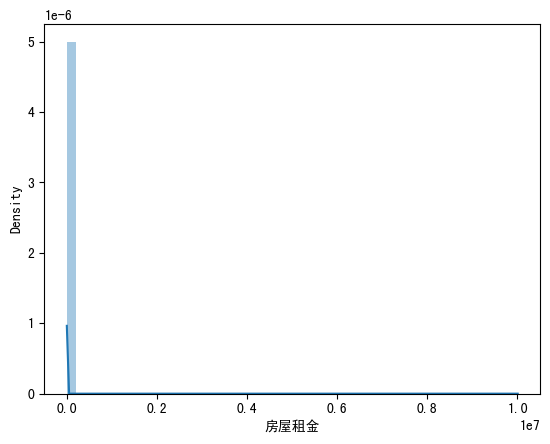

In [21]:
#房屋租金的分布
sns.distplot(df_train['房屋租金'].dropna())

<AxesSubplot:xlabel='房屋租金', ylabel='Density'>

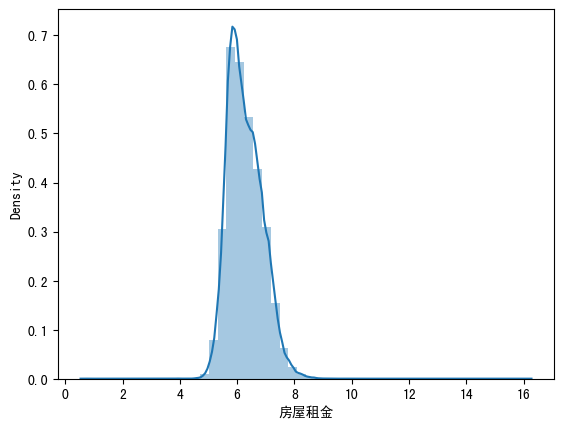

In [22]:
#将其取对数np.log1p
sns.distplot(np.log1p(df_train['房屋租金'].dropna()))

In [23]:
#取对数之后符合正态分布
df_train['房屋租金'] = np.log1p(df_train['房屋租金'])

In [25]:
#平均每个房间的居住面积
df_train['居住面积_mean'] = df_train['居住面积'] / df_train['房间数量']
df_test['居住面积_mean'] = df_test['居住面积'] / df_test['房间数量']

<AxesSubplot:xlabel='居住面积', ylabel='Density'>

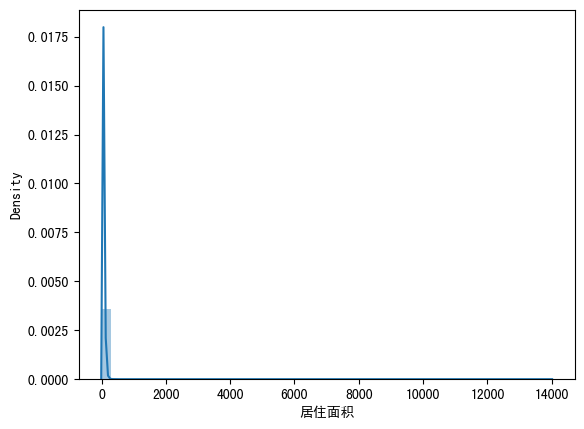

In [26]:
#居住面积也属于连续特征，查看分布情况
sns.distplot(df_train['居住面积'])

<AxesSubplot:xlabel='居住面积', ylabel='Density'>

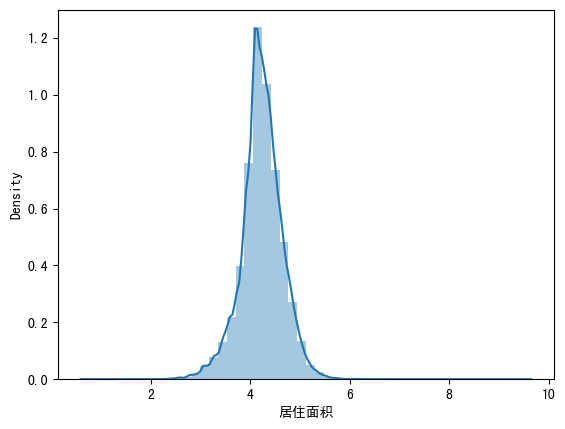

In [27]:
#取对数
sns.distplot(np.log1p(df_train['居住面积']))

In [28]:
df_train['居住面积'] = np.log1p(df_train['居住面积'])

In [30]:
df_test['居住面积'] = np.log1p(df_test['居住面积'])

<AxesSubplot:xlabel='服务费', ylabel='Density'>

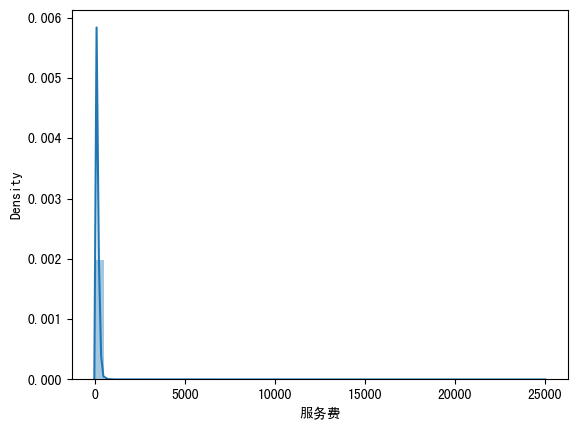

In [31]:
#连续特征服务费
sns.distplot(df_train['服务费'])

In [32]:
df_train['服务费'] = np.log1p(df_train['服务费'])
df_test['服务费'] = np.log1p(df_test['服务费'])

#### 和地址有关的变量为区域1、区域2、区域3、邮政编码,分别可求出其区域内的每平米价格

In [37]:
#区域1
df_train['区域1_每平米价格'] = df_train['区域1'].map(df_train.groupby(['区域1'])['每平米价格'].mean())
df_test['区域1_每平米价格'] = df_test['区域1'].map(df_train.groupby(['区域1'])['每平米价格'].mean())

In [38]:
#区域2
df_train['区域2_每平米价格'] = df_train['区域2'].map(df_train.groupby(['区域2'])['每平米价格'].mean())
df_test['区域2_每平米价格'] = df_test['区域2'].map(df_train.groupby(['区域2'])['每平米价格'].mean())

In [39]:
#区域3
df_train['区域3_每平米价格'] = df_train['区域3'].map(df_train.groupby(['区域3'])['每平米价格'].mean())
df_test['区域3_每平米价格'] = df_test['区域3'].map(df_train.groupby(['区域3'])['每平米价格'].mean())

In [40]:
#邮政编码
df_train['邮政编码_每平米价格'] = df_train['邮政编码'].map(df_train.groupby(['邮政编码'])['每平米价格'].mean())
df_test['邮政编码_每平米价格'] = df_test['邮政编码'].map(df_train.groupby(['邮政编码'])['每平米价格'].mean())

### 所处楼层

In [44]:
#所处楼层的百分比
df_train['所处楼层_div'] = df_train['所处楼层'] / (df_train['建筑楼层'] + 1)#有0层的
df_test['所处楼层_div'] = df_test['所处楼层'] / (df_test['建筑楼层'] + 1)

In [48]:
#是否处于顶层
df_train['所处楼层_max'] = (df_train['所处楼层'] == df_train['建筑楼层']).astype(int)
df_test['所处楼层_max'] = (df_test['所处楼层'] == df_test['所处楼层']).astype(int)

### 建成年份

In [49]:
df_train['建成年份'] = 2022 - df_train['建成年份']
df_test['建成年份'] = 2022 - df_test['建成年份']

### 翻新年龄

In [51]:
df_train['翻新时长'] = 2022 - df_train['最后翻新年份']
df_test['翻新时长'] = 2022 - df_test['最后翻新年份']

### 将train和test放在一起进行价格趋势的特征衍生

In [54]:
data = pd.concat([df_train,df_test], axis=0, ignore_index=True)

In [55]:
#地址的特征选择邮政编码、区域1、区域2、区域3、街道
col_place = ['邮政编码','区域1','区域2','区域3','街道']

In [57]:
#价格趋势平均值
for col in col_place:
    data[col+'_价格趋势'] = data[col].map(data.groupby([col])['价格趋势'].mean())

In [58]:
#价格趋势最大值
for col in col_place:
    data[col+'_价格趋势2'] = data[col].map(data.groupby([col])['价格趋势'].max())

In [59]:
#价格趋势最小值
for col in col_place:
    data[col+'_价格趋势3'] = data[col].map(data.groupby([col])['价格趋势'].min())

### 将train和test放在一起进行建成年份的特征衍生

In [60]:
#平均值
for col in col_place:
    data[col+'_建成年份'] = data[col].map(data.groupby([col])['建成年份'].mean())

In [61]:
#最大值
for col in col_place:
    data[col+'_建成年份2'] = data[col].map(data.groupby([col])['建成年份'].max())

In [62]:
#最小值
for col in col_place:
    data[col+'_建成年份3'] = data[col].map(data.groupby([col])['建成年份'].min())

### 建筑楼层

In [63]:
for col in col_place:
    data[col + '_建筑楼层'] = data[col].map(data.groupby([col])['建筑楼层'].mean())

### 对于区域内的有阳台、有花园、有电梯、有厨房、是新建筑的统计

In [64]:
for col in col_place:
    data[col + '_有阳台'] = data[col].map(data.groupby([col])['有阳台'].sum())
    data[col + '_有花园'] = data[col].map(data.groupby([col])['有花园'].sum())
    data[col + '_有电梯'] = data[col].map(data.groupby([col])['有电梯'].sum())
    data[col + '_有厨房'] = data[col].map(data.groupby([col])['有厨房'].sum())
    data[col + '_是新建筑'] = data[col].map(data.groupby([col])['是新建筑'].sum())

In [68]:
#各个地点的数量
dict_num = dict(data['邮政编码'].value_counts())
data['邮政编码的数量'] = np.log1p(data['邮政编码'].map(dict_num))
dict_num = dict(data['区域1'].value_counts())
data['区域1数量'] = np.log1p(data['邮政编码'].map(dict_num))
dict_num = dict(data['区域2'].value_counts())
data['区域2数量'] = np.log1p(data['区域2'].map(dict_num))
dict_num = dict(data['区域3'].value_counts())
data['区域3数量'] = np.log1p(data['区域3'].map(dict_num))
dict_num = dict(data['街道'].value_counts())
data['街道数量'] = np.log1p(data['街道'].map(dict_num))

## 分离出train和test集合

In [70]:
df_train = data[data['房屋租金'].notnull()].reset_index(drop=True)
df_test = data[data['房屋租金'].isnull()].reset_index(drop=True)

In [75]:
#特征列
features = df_train.columns.unique()
features = features.drop(['房屋租金', 'ID','每平米价格'])

In [76]:
x = df_train[features]
y = df_train['房屋租金']

In [99]:
#模型训练函数
def cv_model(clf,train_x,train_y,test_x,clf_name):
    #clf:模型的名字
    #train_x:有标签数据的特征
    #train_y:有标签数据的label
    #test_y:无标签数据的特征
    #分类器名字
    folds = 12
    seed = 2022
    kf = KFold(n_splits=folds,shuffle=True,random_state=2022)
    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])
    cv_scores = []
    for i,(trn_index,valid_index) in enumerate(kf.split(train_x,train_y)):
        print('----------------------------{}-----------------------------'.format(i))
        trn_x,trn_y,val_x,val_y = train_x.iloc[trn_index],train_y.iloc[trn_index],train_x.iloc[valid_index],train_y.iloc[valid_index]
        if clf_name == 'xgb':
            train_matrix = clf.DMatrix(trn_x,trn_y)
            valid_matrix = clf.DMatrix(val_x,val_y)
            test_matrix = clf.DMatrix(test_x)
            
            param = {'max_depth':8,
                     'objective':'reg:linear',
                     'eval_metric':'mae',
                     'learning_rate':0.1}
            param['gpu_id'] = 0
            param['tree_method'] = 'gpu_hist'
            watch_list = [(train_matrix,'train'),(valid_matrix,'eval')]
            model = clf.train(param,train_matrix,num_boost_round=8000,evals=watch_list,verbose_eval=100,early_stopping_rounds=100)
            val_pred = model.predict(valid_matrix)
            test_pred = model.predict(test_matrix)
            test += test_pred
        
    test = test / kf.n_splits
        
    return test
        
        

In [100]:
def xgb_model(xtrain,ytrain,test_x):
    xgb_test = cv_model(xgb,xtrain,ytrain,test_x,'xgb')
    return xgb_test

In [101]:
xgb_test = xgb_model(x,y,df_test[features])

----------------------------0-----------------------------
[17:23:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:5.19982	eval-mae:5.19436
[100]	train-mae:0.09827	eval-mae:0.10757
[200]	train-mae:0.08932	eval-mae:0.10423
[300]	train-mae:0.08239	eval-mae:0.10210
[400]	train-mae:0.07720	eval-mae:0.10088
[500]	train-mae:0.07205	eval-mae:0.09978
[600]	train-mae:0.06760	eval-mae:0.09905
[700]	train-mae:0.06339	eval-mae:0.09834
[800]	train-mae:0.05977	eval-mae:0.09797
[900]	train-mae:0.05649	eval-mae:0.09760
[1000]	train-mae:0.05319	eval-mae:0.09721
[1100]	train-mae:0.05024	eval-mae:0.09682
[1200]	train-mae:0.04753	eval-mae:0.09646
[1300]	train-mae:0.04499	eval-mae:0.09622
[1400]	train-mae:0.04264	eval-mae:0.09602
[1500]	train-mae:0.04043	eval-mae:0.09581
[1600]	train-mae:0.03844	eval-mae:0.09561
[1700]	train-mae:0.03660	eval-mae:0.09548
[1800]	train-mae:0.03473	eval-mae:0.09536
[1900]	train-mae:0.03298	eval-mae:0.